# Requirements
* Install `pytorch`
* You need python 3.5
* Run the following commands on your bash screen:

```
$ git clone https://github.com/Diviyan-Kalainathan/CausalDiscoveryToolbox.git  # Download the package 
$ cd CausalDiscoveryToolbox
$ pip install -r requirements.txt  # Install the requirements
$ python setup.py install develop --user

```
**NOTE** Be careful about the last line that install the requirements. It is better to install them using `conda install -c anaconda ` instead. This way you don't mess up your python.

Run the following:
```
pip install causality
```

# Setting up environment

In [1]:
import os
import sys

sys.path.append('/Users/kayhan/Projects/gitSandBox/CausalDiscoveryToolbox')

# I am not sure we need all of the following -- clean up
import cdt
from cdt import SETTINGS
SETTINGS.verbose=False
SETTINGS.NB_JOBS=4
import networkx as nx
import time
# A warning on R libraries might occur. It is for the use of the r libraries that could be imported into the framework
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


Detecting 0 CUDA devices.
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NB_JOBS to cpu_count.


# Rearding data from Lung Cancer
The dataset of this notebook are adopted from here:
https://github.com/Diviyan-Kalainathan/CausalDiscoveryToolbox/blob/master/examples/Discovery_LUCAS.ipynb

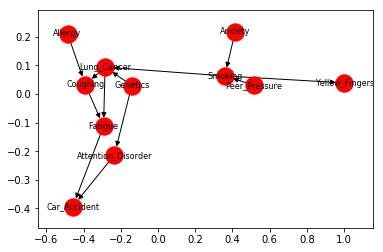

,Allergy,Anxiety,Genetics,Peer_Pressure,Attention_Disorder,Smoking,Lung_Cancer,Yellow_Fingers,Coughing,Fatigue,Car_Accident
0,-0.266076,0.460788,-0.359440,-0.403187,-0.228317,1.334455,0.574623,1.163336,0.982726,-0.840672,-0.508322
1,-0.579084,-0.846836,-0.295204,0.302683,-0.256269,-1.637193,-1.395067,0.154516,0.341314,0.933638,-1.075662
2,-0.105876,0.603170,-0.246007,-0.066926,-0.100983,0.500359,0.329122,0.199425,0.314847,-0.143226,-0.755328
3,0.727293,-0.949493,0.749637,-0.595794,0.809405,-0.586919,-0.130269,-0.840610,-0.691177,0.303761,-0.431910
4,-0.175018,-0.820478,-0.432949,-0.729511,-0.753609,-0.219810,-0.700120,-0.733240,-0.149308,0.854195,-0.633940


In [7]:
# Load data and graph solution
data = pd.read_csv("NUM_LUCAS.csv")
solution = cdt.utils.read_list_edges("Lucas_graph.csv")  
nx.draw_networkx(solution, font_size=8,k=0.15,iterations=200) # The plot function allows for quick visualization of the graph. 
plt.show()
data.head()

In this part of the course, we do not focus on the how this graphs is given, we assume that it is given.

# What can (or cannot) learn from a regression
Let's focus on three variables: *Yellow Finger* ($X$), *Smoking* ($Y$) , and *Lung Cancer* ($Z$). Let's say someone claims that yellow finger results in lung cancer! He say, I did a regression and they are correlated:

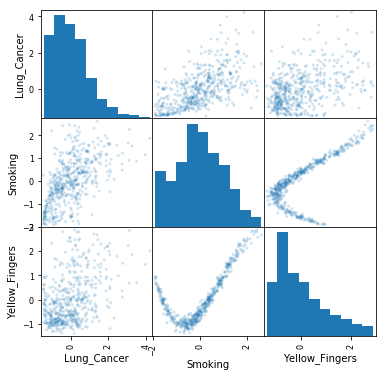

In [3]:
from pandas.plotting import scatter_matrix

_ = scatter_matrix(data[['Lung_Cancer','Smoking','Yellow_Fingers']], alpha=0.2, figsize=(6, 6), diagonal='hist')

In [4]:
from statsmodels.regression.linear_model import OLS

model = OLS(data[['Lung_Cancer']], data[['Yellow_Fingers']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Lung_Cancer   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     114.3
Date:                Wed, 23 May 2018   Prob (F-statistic):           3.65e-24
Time:                        11:45:03   Log-Likelihood:                -657.90
No. Observations:                 500   AIC:                             1318.
Df Residuals:                     499   BIC:                             1322.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Yellow_Fingers     0.4317      0.040     10.692      0.000       0.352       0.511
==============================================================================
Omnibus:                       43.357   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.564
Skew:                           0.702   Prob(JB):                     1.42e-12
Kurtosis:                       3.804   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What if we combine it with smoking history:

In [5]:
model = OLS(data[['Lung_Cancer']],data[['Yellow_Fingers','Smoking']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Lung_Cancer   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     128.4
Date:                Wed, 23 May 2018   Prob (F-statistic):           1.04e-45
Time:                        11:47:06   Log-Likelihood:                -605.48
No. Observations:                 500   AIC:                             1215.
Df Residuals:                     498   BIC:                             1223.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Yellow_Fingers     0.0210      0.053      0.398      0.691      -0.083       0.125
Smoking            0.5680      0.053     10.779      0.000       0.464       0.672
==============================================================================
Omnibus:                       63.411   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.851
Skew:                           0.858   Prob(JB):                     6.88e-21
Kurtosis:                       4.230   Cond. No.                         2.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## P-Value is not everything
You can see from the graph that genetic has indirect effect on the car accident through attention disorder. Let's perform gression:

In [13]:
print("(Genetics) -> Car_Accident ")
model = OLS(data[['Car_Accident']],data[['Genetics']])
result = model.fit()
result.summary() 

(Genetics) -> Car_Accident 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Car_Accident   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.201
Date:                Wed, 23 May 2018   Prob (F-statistic):              0.274
Time:                        12:18:50   Log-Likelihood:                -708.87
No. Observations:                 500   AIC:                             1420.
Df Residuals:                     499   BIC:                             1424.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Genetics      -0.0833      0.076     -1.096      0.274      -0.233       0.066
==============================================================================
Omnibus:                      227.556   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1470.171
Skew:                           1.881   Prob(JB):                         0.00
Kurtosis:                      10.511   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value does not show significant association! Remeber, this is the p-value of the null hypothesis. If p-value is not less than a threshold, all it means is that "there is not *enough* evidence to reject the null hypothesis." Not rejecting the null hypothesis does not mean that we can accept it!

# Funny business of the V-structure
Does lung cancer results in allergy ? We do **Not** expect the answer to that question to be "Yes" because one can these two seems to be independent. Let's run regression both ways and inspect the results:

In [18]:
print("(Lung_Cancer) -> Allergy ")
model = OLS(data[['Allergy']],data[['Lung_Cancer']])
result = model.fit()
print( result.summary() )


print("(Allergy) -> Lung_Cancer ")
model = OLS(data[['Lung_Cancer']],data[['Allergy']])
result = model.fit()
print( result.summary() )



(Lung_Cancer) -> Allergy 
                            OLS Regression Results                            
Dep. Variable:                Allergy   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.720
Date:                Wed, 23 May 2018   Prob (F-statistic):             0.0997
Time:                        12:42:45   Log-Likelihood:                -419.78
No. Observations:                 500   AIC:                             841.6
Df Residuals:                     499   BIC:                             845.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Lung_Cancer     0.0414  

As expected, the p-value of the regression is not significant in either way. 

**Question**: What if we include the Coughing into the regression?

In [20]:
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("(Coughing, Lung_Cancer) -> Allergy ")
model = OLS(data[['Allergy']],data[['Coughing','Lung_Cancer']])
result = model.fit()
print( result.summary() )

print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("(Coughing, Allergy) -> Lung_Cancer ")
model = OLS(data[['Lung_Cancer']],data[['Coughing','Allergy']])
result = model.fit()
print( result.summary() )

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
(Coughing, Lung_Cancer) -> Allergy 
                            OLS Regression Results                            
Dep. Variable:                Allergy   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     566.5
Date:                Wed, 23 May 2018   Prob (F-statistic):          5.11e-129
Time:                        12:49:08   Log-Likelihood:                -124.55
No. Observations:                 500   AIC:                             253.1
Df Residuals:                     498   BIC:                             261.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------

Wow! in both regressions "Allergy" and "Lung Cancer" become associated! However, this happens due to the presence of "Coughing." Both allergy and lung cancer can cause coughing, so there is so-called V-structure there $\text{Allergy} \rightarrow \text{Coughing} \leftarrow \text{Lung Cancer}$. If I know someone is coughing and he does not have lung cancer, I may conclude that he has an allergy. Of course, this is a simple world, and I am assuming there is no other explanation!

#################

**Question :** If I run two regressions to predict variable $Y$, say $(X) \rightarrow Y$ and $(X,Z) \rightarrow Y$. In the second one, $Z$ becomes insignificant. Can I infer that $Z$ has indirect effect?

In [12]:
print("(Genetics) -> Car_Accident ")
model = OLS(data[['Car_Accident']],data[['Genetics']])
result = model.fit()
print( result.summary() )

print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
print("(Genetics, Attention_Disorder) -> Car_Accident ")
model = OLS(data[['Car_Accident']],data[['Attention_Disorder','Fatigue']])
result = model.fit()
print( result.summary() )

(Genetics) -> Car_Accident 
                            OLS Regression Results                            
Dep. Variable:           Car_Accident   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.201
Date:                Wed, 23 May 2018   Prob (F-statistic):              0.274
Time:                        12:11:45   Log-Likelihood:                -708.87
No. Observations:                 500   AIC:                             1420.
Df Residuals:                     499   BIC:                             1424.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Genetics      -0.0833   

Interesting! Now that we have included the smoking history, the yellow finger become insignificant. .... [WRITE MORE]

# Conditional Independence

Explain the notion of conditional independce . Use medium..


# What is Propensity score

# Refs
[1] https://medium.com/@akelleh/a-technical-primer-on-causality-181db2575e41

[2] https://medium.com/causal-data-science/understanding-bias-a-pre-requisite-for-trustworthy-results-ee590b75b1be

[3] https://github.com/Diviyan-Kalainathan/causal-humans

[4] https://github.com/Diviyan-Kalainathan/CausalDiscoveryToolbox

[5] https://github.com/Diviyan-Kalainathan/medi-chal

[6] https://github.com/akelleh/causality
